In [52]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2

In [18]:
#setting the path to the directory containing the pics
path = 'C:/Users/jpaul/Ing_ml_P6/dataset/Train'
categories = []
for i in os.listdir(path):
    categories.append(i)

In [75]:
#appending the pics to the training data list
training_data = []
training_label = []
for i in categories:
    for img in os.listdir(path + '/' + i):
        pic = cv2.imread(os.path.join(path + '/' + i,img))
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic,(80,80))
        training_data.append([pic])
        training_label.append(i)

In [84]:
#X_train = np.array(training_data)
X_train = np.array(training_data)
X_train = X_train.reshape((X_train.shape[0], 80, 80, 3))
X_train = X_train.astype('float32')

#Init Y_train
Y_train = np.array(training_label)
Y_train = [i.split('-')[1] for i in Y_train]

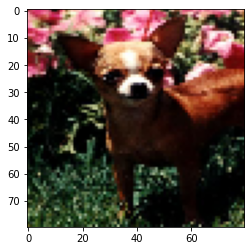

In [87]:
plt.imshow(X_train[0].reshape(80,80,3))
plt.show()

In [90]:
datagen = ImageDataGenerator(zca_whitening=True)
datagen.fit(X_train)

C:\Users\jpaul\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


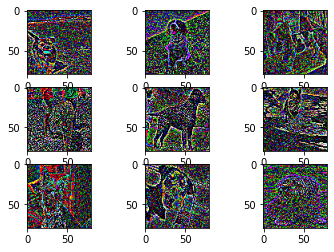

In [92]:
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(80, 80,3), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break